### Creating a Time Series Model on BTCUSD

* Using an AR model, with linear regression ML technique
* If initial obervation shows promise, we will add features within the time series and possibly later correlated pair
* We will be using a linear model but using Pytorch for the weight and bias

In [523]:
from binance.client import Client
import pandas as pd
from datetime import datetime
import polars as pl
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import altair as alt
import matplotlib.pyplot as plt


# Initialize the Binance client (public data only)
client = Client()

# Parameters
symbol = "BTCUSDT"  # Change to any pair you want
interval = "4h"  # e.g. "1m", "15m", "1h", "1d"
start_date = "2020-01-01"  # You can use e.g. "1 Jan, 2020"
end_date = datetime.now().strftime("%d %b, %Y %H:%M:%S")
# Max number of Auto-regressive lags
max_lags =4
# Forecast horizon in steps
forcast_horizon = 1

# Download historical klines
klines = client.get_historical_klines(symbol, interval, start_date, end_date)

# Convert to DataFrame
cols = [
    "timestamp", "open", "high", "low", "close", "volume",
    "close_time", "quote_asset_volume", "num_trades",
    "taker_buy_base", "taker_buy_quote", "ignore"
]

df = pd.DataFrame(klines, columns=cols)

# Convert datatypes
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
numeric_cols = ["open", "high", "low", "close", "volume"]
df[numeric_cols] = df[numeric_cols].astype(float)

# Set index
df.set_index("timestamp", inplace=True)

# Drop unused columns
df = df[["open", "high", "low", "close", "volume"]]

print(df.head())

                        open     high      low    close       volume
timestamp                                                           
2020-01-01 00:00:00  7195.24  7245.00  7175.46  7225.01  2833.749180
2020-01-01 04:00:00  7225.00  7236.27  7199.11  7209.83  2061.295051
2020-01-01 08:00:00  7209.83  7237.73  7180.00  7197.20  3166.654361
2020-01-01 12:00:00  7197.20  7255.00  7196.15  7234.19  3492.537459
2020-01-01 16:00:00  7234.20  7249.99  7214.00  7229.48  2980.583291


### Inspect data

In [524]:
df.describe(include="all")
df['close'].value_counts()
df.isna().mean()

open      0.0
high      0.0
low       0.0
close     0.0
volume    0.0
dtype: float64

In [525]:
ts = df
ts

,open,high,low,close,volume
timestamp,,,,,
2020-01-01 00:00:00,7195.24,7245.00,7175.46,7225.01,2833.749180
2020-01-01 04:00:00,7225.00,7236.27,7199.11,7209.83,2061.295051
2020-01-01 08:00:00,7209.83,7237.73,7180.00,7197.20,3166.654361
2020-01-01 12:00:00,7197.20,7255.00,7196.15,7234.19,3492.537459
2020-01-01 16:00:00,7234.20,7249.99,7214.00,7229.48,2980.583291
...,...,...,...,...,...
2025-11-05 20:00:00,104008.09,104534.74,103305.05,103885.16,2687.898330
2025-11-06 00:00:00,103885.16,103933.33,102716.26,103636.03,3781.794370
2025-11-06 04:00:00,103636.92,104200.00,102910.66,103185.48,2970.865520


<Axes: title={'center': 'BTCUSDT'}, xlabel='timestamp'>

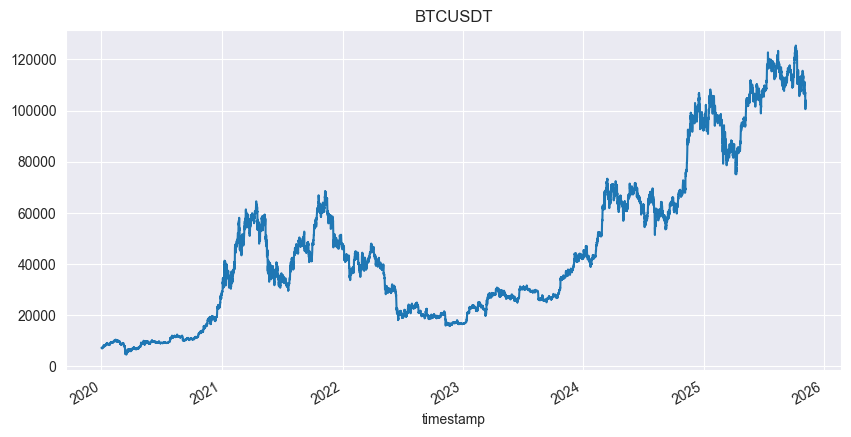

In [526]:
ts['close'].plot(figsize=(10,5),title=symbol)
# can experiment with Altair for dynamic charts later.

### Feature Engineering


### Create target and lagged features using log returns

In [527]:
# Creating log return within ts dataframe.
ts = ts.sort_index()
ts['close_log_return']= np.log(ts['close']/ts['close'].shift(forcast_horizon))
ts

,open,high,low,close,volume,close_log_return
timestamp,,,,,,
2020-01-01 00:00:00,7195.24,7245.00,7175.46,7225.01,2833.749180,NaN
2020-01-01 04:00:00,7225.00,7236.27,7199.11,7209.83,2061.295051,-0.002103
2020-01-01 08:00:00,7209.83,7237.73,7180.00,7197.20,3166.654361,-0.001753
2020-01-01 12:00:00,7197.20,7255.00,7196.15,7234.19,3492.537459,0.005126
2020-01-01 16:00:00,7234.20,7249.99,7214.00,7229.48,2980.583291,-0.000651
...,...,...,...,...,...,...
2025-11-05 20:00:00,104008.09,104534.74,103305.05,103885.16,2687.898330,-0.001183
2025-11-06 00:00:00,103885.16,103933.33,102716.26,103636.03,3781.794370,-0.002401
2025-11-06 04:00:00,103636.92,104200.00,102910.66,103185.48,2970.865520,-0.004357


In [528]:
# Create lagged features
target = 'close_log_return'
max_lags = 4
forcast_horizon = 1

# create 4 lagged features

ts = ts.copy() # this is to avoid setting with copy warning

ts[f'{target}_lag_1'] = ts[target].shift(forcast_horizon * 1)
ts[f'{target}_lag_2'] = ts[target].shift(forcast_horizon * 2)
ts[f'{target}_lag_3'] = ts[target].shift(forcast_horizon * 3)
ts[f'{target}_lag_4'] = ts[target].shift(forcast_horizon * 4)



In [529]:
# better practice would be ts = ts.dropna()
ts.dropna(inplace=True)
ts

,open,high,low,close,volume,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
timestamp,,,,,,,,,,
2020-01-01 20:00:00,7229.48,7242.98,7175.15,7200.85,2257.568823,-0.003968,-0.000651,0.005126,-0.001753,-0.002103
2020-01-02 00:00:00,7200.77,7212.50,7120.37,7129.61,3739.354832,-0.009943,-0.003968,-0.000651,0.005126,-0.001753
2020-01-02 04:00:00,7129.25,7161.00,7105.00,7110.57,4057.961355,-0.002674,-0.009943,-0.003968,-0.000651,0.005126
2020-01-02 08:00:00,7110.98,7180.00,7109.11,7139.79,4162.203010,0.004101,-0.002674,-0.009943,-0.003968,-0.000651
2020-01-02 12:00:00,7139.73,7163.40,7107.43,7130.98,4179.041833,-0.001235,0.004101,-0.002674,-0.009943,-0.003968
...,...,...,...,...,...,...,...,...,...,...
2025-11-05 20:00:00,104008.09,104534.74,103305.05,103885.16,2687.898330,-0.001183,0.002694,0.016110,0.000760,-0.001342
2025-11-06 00:00:00,103885.16,103933.33,102716.26,103636.03,3781.794370,-0.002401,-0.001183,0.002694,0.016110,0.000760
2025-11-06 04:00:00,103636.92,104200.00,102910.66,103185.48,2970.865520,-0.004357,-0.002401,-0.001183,0.002694,0.016110


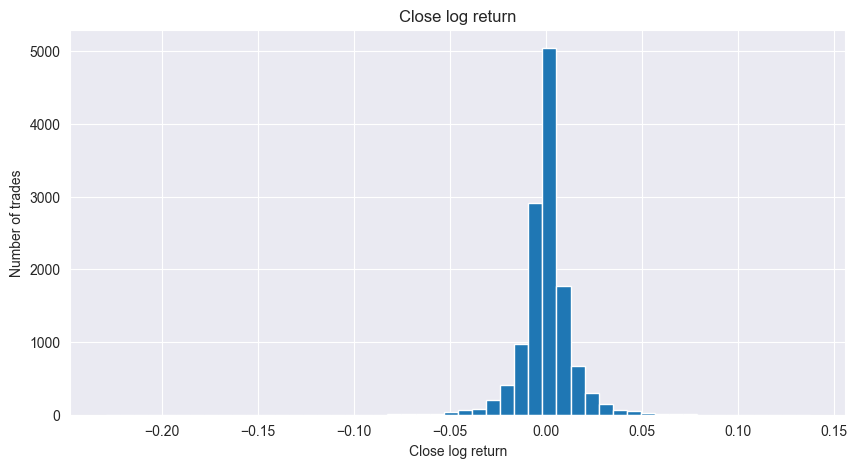

In [530]:
# Plot distribution

ts['close_log_return'].hist(bins=50, figsize=(10,5))
plt.title('Close log return')
plt.xlabel('Close log return')
plt.ylabel('Number of trades')

plt.show()


Text(0.5, 1.0, ' Distribution of Log Returns')

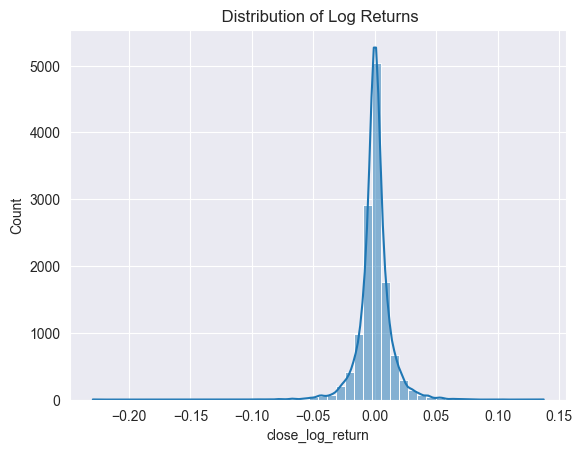

In [531]:
import seaborn as sns
sns.histplot(ts['close_log_return'], bins=50, kde=True)
plt.title(" Distribution of Log Returns")


### Build Model

In [532]:
# we will use a linear model from torch.
# reason for linear model is the simplicity and interpretation
class LinearModel(nn.Module):
    def __init__(self, input_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_features, 1)

    def forward(self, x):
        return self.linear(x)

### Complexity of the model

In [533]:
# y = w * x + b = linear model
input_features = 1
linear_model = LinearModel(input_features)

from torchinfo import summary
#summary(linear_model,input_size=(1, input_features))

print(linear_model)
print(summary(linear_model,input_size=(1, input_features)))


LinearModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)
Layer (type:depth-idx)                   Output Shape              Param #
LinearModel                              [1, 1]                    --
├─Linear: 1-1                            [1, 1]                    2
Total params: 2
Trainable params: 2
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


### Split by time
* Creating an AR1 model
* We are aiming to predict one return by its own lag
* splitting your data by scratch ensures no data leackage

In [534]:
 features = ['close_log_return_lag_1']
 target = 'close_log_return'
 test_size = 0.25 #

In [535]:
len(ts)

12814

In [536]:
len(ts)* test_size

3203.5

In [537]:
# to split the data by time, we will split it by the index.
# this will give us the train size below
split_idx = int(len(ts) *(1-test_size))
split_idx

9610

In [538]:
# split time series into 2 parts

ts_train,ts_test = ts[:split_idx], ts[split_idx:]

ts_train.head()

,open,high,low,close,volume,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
timestamp,,,,,,,,,,
2020-01-01 20:00:00,7229.48,7242.98,7175.15,7200.85,2257.568823,-0.003968,-0.000651,0.005126,-0.001753,-0.002103
2020-01-02 00:00:00,7200.77,7212.50,7120.37,7129.61,3739.354832,-0.009943,-0.003968,-0.000651,0.005126,-0.001753
2020-01-02 04:00:00,7129.25,7161.00,7105.00,7110.57,4057.961355,-0.002674,-0.009943,-0.003968,-0.000651,0.005126
2020-01-02 08:00:00,7110.98,7180.00,7109.11,7139.79,4162.203010,0.004101,-0.002674,-0.009943,-0.003968,-0.000651
2020-01-02 12:00:00,7139.73,7163.40,7107.43,7130.98,4179.041833,-0.001235,0.004101,-0.002674,-0.009943,-0.003968


In [539]:
ts_test.tail()

,open,high,low,close,volume,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
timestamp,,,,,,,,,,
2025-11-05 20:00:00,104008.09,104534.74,103305.05,103885.16,2687.89833,-0.001183,0.002694,0.016110,0.000760,-0.001342
2025-11-06 00:00:00,103885.16,103933.33,102716.26,103636.03,3781.79437,-0.002401,-0.001183,0.002694,0.016110,0.000760
2025-11-06 04:00:00,103636.92,104200.00,102910.66,103185.48,2970.86552,-0.004357,-0.002401,-0.001183,0.002694,0.016110
2025-11-06 08:00:00,103184.75,103440.00,102651.63,103227.58,2657.25315,0.000408,-0.004357,-0.002401,-0.001183,0.002694
2025-11-06 12:00:00,103227.59,103333.18,102830.83,102867.05,290.34088,-0.003499,0.000408,-0.004357,-0.002401,-0.001183


In [540]:
# converting into torch tensors
# splitting our input and output into separate variables
X_train = torch.tensor(ts_train[features].to_numpy(), dtype=torch.float32)
X_test = torch.tensor(ts_test[features].to_numpy(), dtype=torch.float32)
Y_train = torch.tensor(ts_train[target].to_numpy(), dtype=torch.float32)
Y_test = torch.tensor(ts_test[target].to_numpy(), dtype=torch.float32)



In [541]:
X_train.shape # row vector


torch.Size([9610, 1])

In [542]:
Y_train.shape # one dimensional tensor

torch.Size([9610])

In [543]:
# We need to put it into a 2 dimensional

Y_train = Y_train.reshape(-1, 1)
Y_train.shape

torch.Size([9610, 1])

In [544]:
Y_test = Y_test.reshape(-1, 1)
Y_test.shape

torch.Size([3204, 1])

In [545]:
# Fit scaler on TRAIN only
from sklearn.preprocessing import StandardScaler

x_scaler = StandardScaler().fit(ts_train[features].values)
X_train_np = x_scaler.transform(ts_train[features].values)
X_test_np  = x_scaler.transform(ts_test[features].values)

# Replace your old torch tensor creation with:
X_train = torch.tensor(X_train_np, dtype=torch.float32)
X_test  = torch.tensor(X_test_np,  dtype=torch.float32)


### Batch Gradient Descent
* this trains all the data at once.

In [546]:
# specify hyperparameters which can be tweaked to improve model performance

no_epochs = 1000 * 5
lr = 0.0005

# Create Model
model = LinearModel(len(features))

#Loss Function L1Loss/MSE
criterion = nn.L1Loss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

print('\nTraining...')
for epoch in range(no_epochs):
    # forward pass
    y_hat = model(X_train)
    loss = criterion(y_hat, Y_train)

    # Backward pass
    optimizer.zero_grad() # 1. clear old gradients
    loss.backward()       # 2. compute new gradients
    optimizer.step()      # 3. update weights

    # check for improvements by logging
    train_loss = loss.item()

    # logging
    if (epoch+1) % 500 == 0:
        print(f'Epoch [{epoch+1}/{no_epochs}], Loss: {train_loss:.6f}')

    print('\nLearned parameters:')

    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f'{name}:\n {param.data.numpy()}')

    # Evaluation
    model.eval()
    with torch.no_grad():
        y_hat = model(X_test)
        test_loss = criterion(y_hat, Y_test)
        print(f'\nTest loss: {test_loss.item():.6f}, Train loss: {train_loss:.6f}')





Training...

Learned parameters:
linear.weight:
 [[-0.39072654]]
linear.bias:
 [0.82768065]

Test loss: 0.836617, Train loss: 0.844896

Learned parameters:
linear.weight:
 [[-0.39022663]]
linear.bias:
 [0.8271806]

Test loss: 0.836096, Train loss: 0.844348

Learned parameters:
linear.weight:
 [[-0.38972673]]
linear.bias:
 [0.8266806]

Test loss: 0.835575, Train loss: 0.843800

Learned parameters:
linear.weight:
 [[-0.38922685]]
linear.bias:
 [0.8261806]

Test loss: 0.835054, Train loss: 0.843251

Learned parameters:
linear.weight:
 [[-0.38872704]]
linear.bias:
 [0.82568055]

Test loss: 0.834533, Train loss: 0.842703

Learned parameters:
linear.weight:
 [[-0.38822728]]
linear.bias:
 [0.82518053]

Test loss: 0.834012, Train loss: 0.842155

Learned parameters:
linear.weight:
 [[-0.38772762]]
linear.bias:
 [0.8246805]

Test loss: 0.833491, Train loss: 0.841607

Learned parameters:
linear.weight:
 [[-0.38722804]]
linear.bias:
 [0.8241805]

Test loss: 0.832970, Train loss: 0.841059

Learned

### Looking at the weight, which is negative, the model picked up a mean reversion adoption.

### Test Trading performance
* Create trade results from test data

In [547]:
trade_results = pl.DataFrame({
    'y_hat': y_hat.squeeze(),
    'y': Y_test.squeeze(),
}).with_columns(
    (pl.col('y_hat').sign()==pl.col('y').sign()).alias('is_won'),
    pl.col('y_hat').sign().alias('signal'),
).with_columns(
    (pl.col('signal') * pl.col('y')).alias('trade_log_return')
    ).with_columns(
        pl.col('trade_log_return').cum_sum().alias('equity_curve')
    )
trade_results

y_hat,y,is_won,signal,trade_log_return,equity_curve
f32,f32,bool,f32,f32,f32
0.001715,-0.007778,false,1.0,-0.007778,-0.007778
0.000889,0.012369,true,1.0,0.012369,0.004592
-0.000665,-0.00275,true,-1.0,0.00275,0.007341
0.000501,-0.003447,false,1.0,-0.003447,0.003894
0.000555,0.000303,true,1.0,0.000303,0.004197
…,…,…,…,…,…
0.000081,-0.001183,false,1.0,-0.001183,0.97953
0.00038,-0.002401,false,1.0,-0.002401,0.977129
0.000474,-0.004357,false,1.0,-0.004357,0.972772


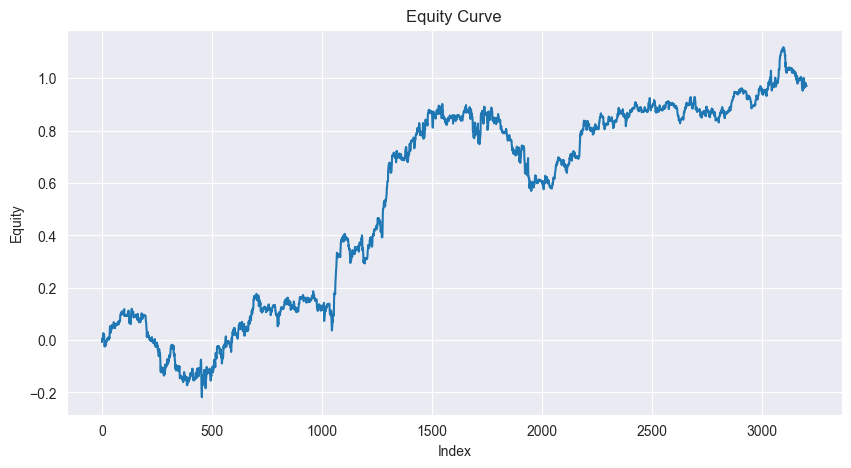

In [548]:
# plot equity curve
# Convert the Series to a NumPy array for plotting
y = trade_results['equity_curve'].to_numpy()

plt.figure(figsize=(10,5))
plt.plot(y)
plt.title("Equity Curve")
plt.xlabel("Index")
plt.ylabel("Equity")
plt.show()



In [549]:
# performance checking
trade_results = trade_results.with_columns(
    (pl.col('equity_curve')-pl.col('equity_curve').cum_max()).alias('drawdown_log')
)
trade_results

y_hat,y,is_won,signal,trade_log_return,equity_curve,drawdown_log
f32,f32,bool,f32,f32,f32,f32
0.001715,-0.007778,false,1.0,-0.007778,-0.007778,0.0
0.000889,0.012369,true,1.0,0.012369,0.004592,0.0
-0.000665,-0.00275,true,-1.0,0.00275,0.007341,0.0
0.000501,-0.003447,false,1.0,-0.003447,0.003894,-0.003447
0.000555,0.000303,true,1.0,0.000303,0.004197,-0.003144
…,…,…,…,…,…,…
0.000081,-0.001183,false,1.0,-0.001183,0.97953,-0.138885
0.00038,-0.002401,false,1.0,-0.002401,0.977129,-0.141286
0.000474,-0.004357,false,1.0,-0.004357,0.972772,-0.145643


In [550]:
# Max DD log

max_drawdown_log = trade_results['drawdown_log'].min()
max_drawdown_log

-0.3377569913864136

In [551]:
# Putting into simple returns
drawdown_pct = np.exp(max_drawdown_log)-1
drawdown_pct

np.float64(-0.28663137844365627)

In [552]:
equity_peak = 1000
equity_peak * drawdown_pct

np.float64(-286.6313784436563)

In [553]:
# Win rate
win_rate = trade_results['is_won'].mean()
win_rate

0.5271535580524345

In [554]:
# Expected Value
avg_win = trade_results.filter(pl.col('is_won')==True)['trade_log_return'].mean()
avg_loss = trade_results.filter(pl.col('is_won')==False)['trade_log_return'].mean()
ev= win_rate * avg_win + (1-win_rate) * avg_loss
ev

0.0003026475168193313

In [555]:
# total log return
total_log_return = trade_results['trade_log_return'].sum()
total_log_return

0.9696826934814453

In [556]:
compound_return = np.exp(total_log_return)
compound_return

np.float64(2.6371075551662133)

In [557]:
1000*compound_return

np.float64(2637.1075551662134)

In [558]:
# Equity trough

equity_trough = trade_results['equity_curve'].min()
equity_trough

-0.21833735704421997

In [559]:
# Equity peak

equity_peak = trade_results['equity_curve'].max()
equity_peak

1.1184154748916626

In [560]:
# std
std = trade_results['trade_log_return'].std()
std

0.009925328195095062

In [565]:
# Sharpe
annualized_rate = np.sqrt(365*24/4)
sharpe = ev / std * annualized_rate
sharpe


np.float64(1.4269682037930358)

In [562]:
# Highlighting itertools
import itertools
max_lags = 4
benchmarks = []
feature_pool = [f'{target}_lag_{i}' for i in range(1, max_lags + 1)]
combos = list(itertools.combinations(feature_pool, 1))

for features in combos:
    model = LinearModel(len(features))
    benchmarks.append()(ts,list(features),target, model, annualized_rate,no_epochs=200,loss=nn.L1Loss())

    benchmarks = pl.DataFrame(benchmarks)




TypeError: list.append() takes exactly one argument (0 given)

### Adding Transaction Fees

In [563]:
# 2 types of fees:
# 1: maker fee and taker fee

maker_fee = 0.0001
taker_fee = 0.0003

roundtrip_fee_log = np.log(1-2*maker_fee)

trade_results = trade_results.with_columns(pl.lit(roundtrip_fee_log).alias('tx_fee_log'))
trade_results = trade_results.with_columns((pl.col('trade_log_return')+pl.col('tx_fee_log')).alias('trade_log_return_net'))
trade_results = trade_results.with_columns(pl.col('trade_log_return_net').cum_sum().alias('equity_curve_net'))
trade_results

roundtrip_fee_log
#trade_results


np.float64(-0.0002000200026670447)

### Our Initial time_interval resulted in a negative equity after fees. I adjusted in the following ways
### tweaks
* Increased time horizon from 1H to 4H and used the lag_1 feature.After scanning through all single features, lag_1 resulted in highest performance
* We can add further features next
* We can explore correlation next

### I have adjusted the lag to 1 and put the time_interval to 4h. This has increased the sharpe and net equity.

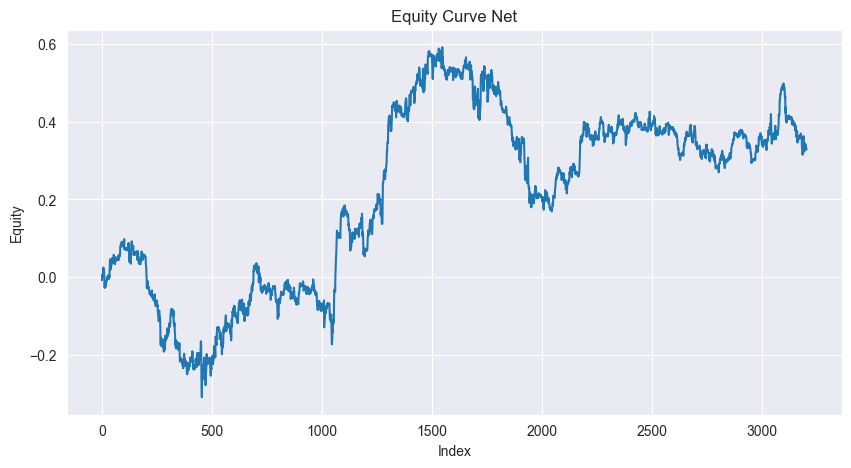

In [564]:
y = trade_results['equity_curve_net'].to_numpy()

plt.figure(figsize=(10,5))
plt.plot(y)
plt.title("Equity Curve Net")
plt.xlabel("Index")
plt.ylabel("Equity")
plt.show()

In [398]:
trade_results['is_won'].mean()

0.5271535580524345

### Now to create my own research module to adjust models and their functions without changing the full model.
### This will assist in identifying strength of model between features.

In [ ]:
%%sql
# Save